In [1]:
# import neessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import pickle

In [ ]:
with open("intermediate/dfs_dict.pickle", "rb") as f:
    dfs_dict = pickle.load(f)

df_wind = dfs_dict["Wind"]

In [ ]:
df_wind[df_wind["exterior_temperature"].isna()]

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
1043621,19,2022-12-01 21:00:00,12.5,-273.0,1962.0,17.8,NaN,NaN,1


In [ ]:
df_wind['read_at'] = pd.to_datetime(df_wind['read_at'])
filtered_df = df_wind[(df_wind['asset_id'] == 19) & 
                 (df_wind['read_at'].dt.time == pd.to_datetime('21:00:00').time()) & 
                 (df_wind['read_at'].dt.month == 12) & 
                 (df_wind['read_at'].dt.day == 1)] 
filtered_df

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
991062,19,2021-12-01 21:00:00,12.0,-52.0,2047.0,17.97,2.0,5.0,1
1043621,19,2022-12-01 21:00:00,12.5,-273.0,1962.0,17.80,NaN,NaN,1


In [ ]:
df_wind.loc[df_wind["exterior_temperature"].isna(), "exterior_temperature"] = filtered_df["exterior_temperature"].median()
df_wind.loc[df_wind["nacelle_temperature"].isna(), "nacelle_temperature"] = filtered_df["nacelle_temperature"].median()

In [ ]:
df_wind[(df_wind['asset_id'] == 19) & 
                 (df_wind['read_at'].dt.time == pd.to_datetime('21:00:00').time()) & 
                 (df_wind['read_at'].dt.month == 12) & 
                 (df_wind['read_at'].dt.day == 1)] 

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
991062,19,2021-12-01 21:00:00,12.0,-52.0,2047.0,17.97,2.0,5.0,1
1043621,19,2022-12-01 21:00:00,12.5,-273.0,1962.0,17.80,2.0,5.0,1


wind speed vs power average

exterior temperature vs power average

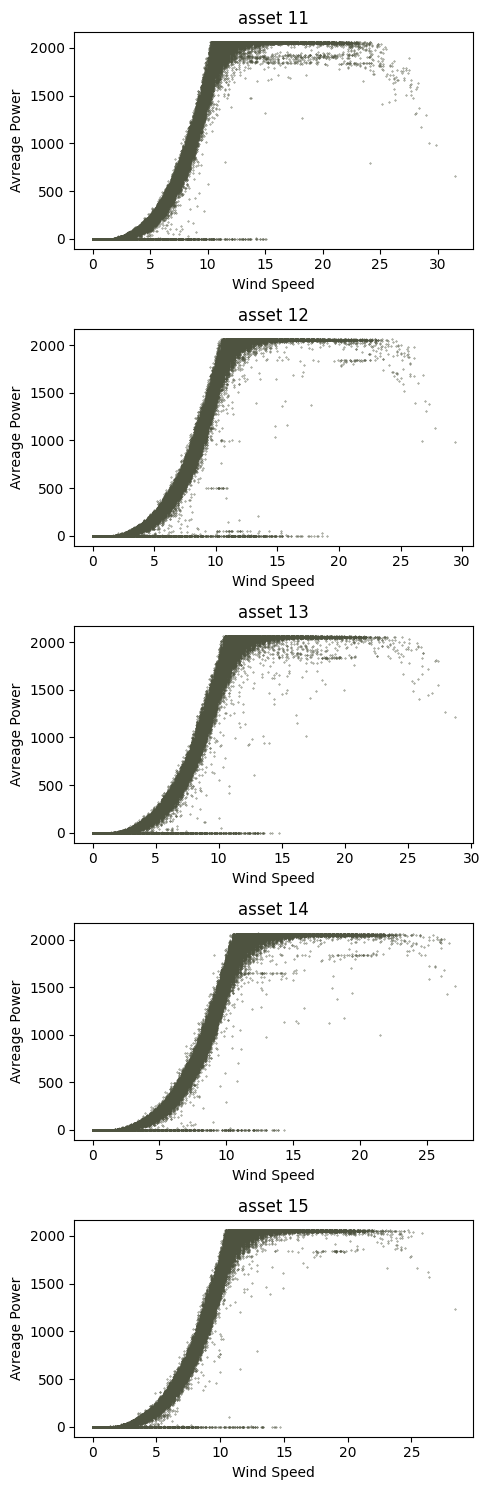

In [ ]:
plot = 1
assets = df_wind["asset_id"].unique()[:5]
n_plots = 5
plt.figure(figsize=(5, n_plots*3))
for asset, subset in df_wind[df_wind["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(n_plots, 1, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('Wind Speed')
    plt.ylabel('Avreage Power')
    plt.scatter(subset["wind_speed"], subset["power_average"], c="#4E5340", s=0.1)
    plot += 1
plt.tight_layout()
plt.show()

test the DBSCAN method to identify outliers:

Number of outliers for Asset 11: 2815


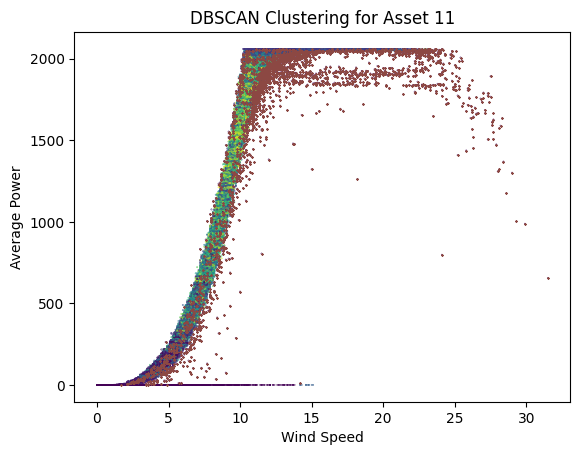

Number of outliers for Asset 12: 2189


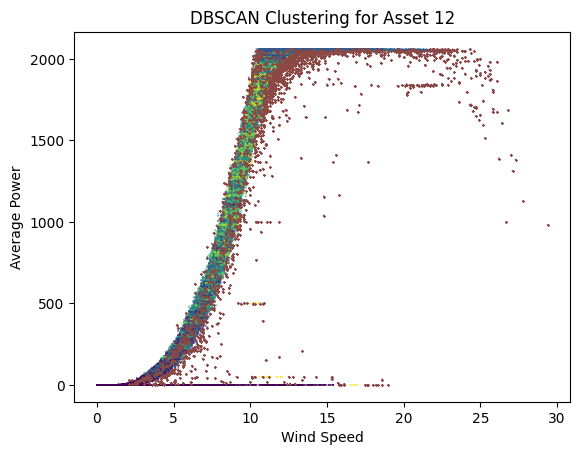

Number of outliers for Asset 13: 2544


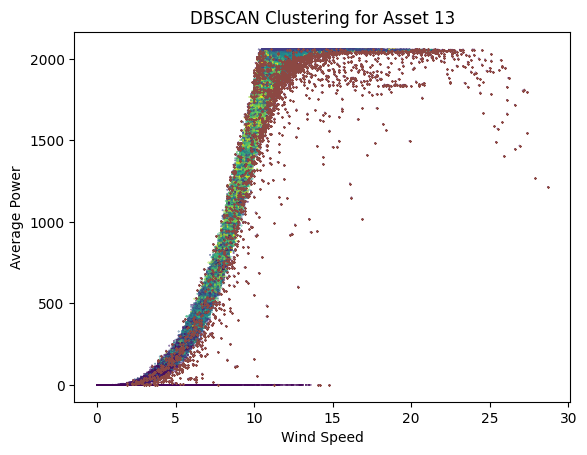

Number of outliers for Asset 14: 2287


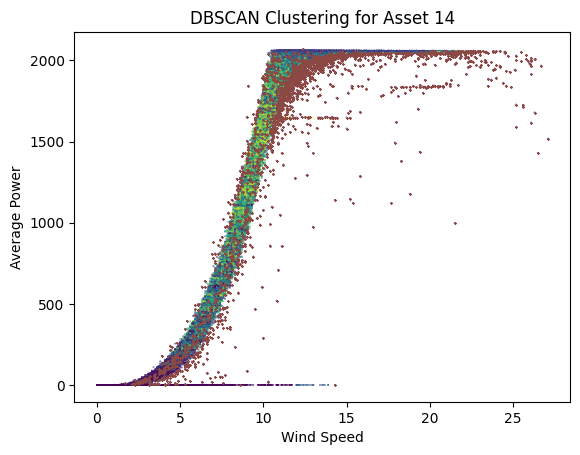

Number of outliers for Asset 15: 2021


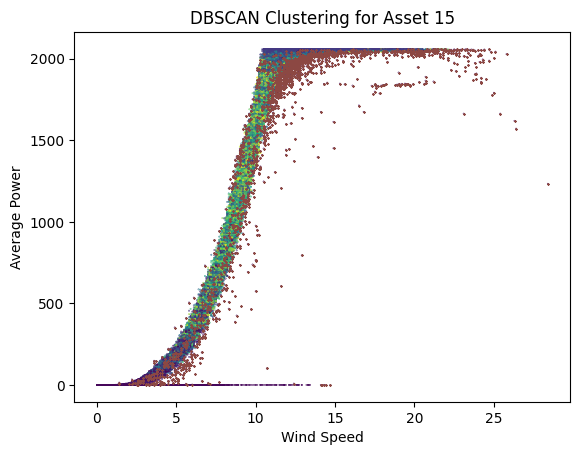

In [ ]:
# Define the DBSCAN parameters
eps = 0.3
min_samples = 5

# Iterate over the first 5 assets
for asset_id in df_wind['asset_id'].unique()[:5]:
    # Filter the data for the current asset
    filtered_data = df_wind[df_wind['asset_id'] == asset_id][['wind_speed', 'power_average']]

    # Create the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(filtered_data)

    # Get the labels of the data points
    labels = dbscan.labels_

    # Identify the outliers
    outliers = np.where(labels == -1)[0]

    # Print the number of outliers
    print(f"Number of outliers for Asset {asset_id}:", len(outliers))

    # Plot the data with the outliers highlighted
    plt.scatter(filtered_data['wind_speed'], filtered_data['power_average'], c=labels, label = "Remaining Points" , s=0.1)
    plt.scatter(filtered_data.iloc[outliers, 0], filtered_data.iloc[outliers, 1], c="#8C4843", marker="x", label = "Outlier",s=1)
    plt.title(f'DBSCAN Clustering for Asset {asset_id}')
    plt.xlabel('Wind Speed')
    plt.ylabel('Average Power')
    plt.show()


Mean square deviation method:

In [ ]:
with open("intermediate/dfs_dict.pickle", "rb") as f:
    dfs_dict = pickle.load(f)

df_wind = dfs_dict["Wind"]

/tmp/ipykernel_4918/2850954147.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df_wind.groupby([wind_speed_intervals, "asset_id"])
/tmp/ipykernel_4918/2850954147.py:14: RuntimeWarning: invalid value encountered in scalar divide
  mean_square_deviation = np.sqrt(((group_df['power_average'] - mean_power) ** 2).sum() / (n - 1))


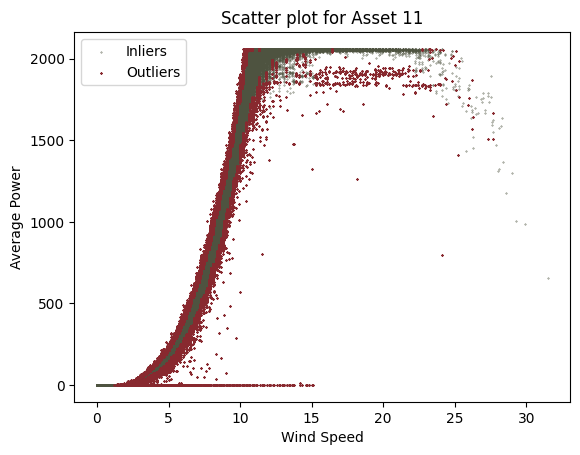

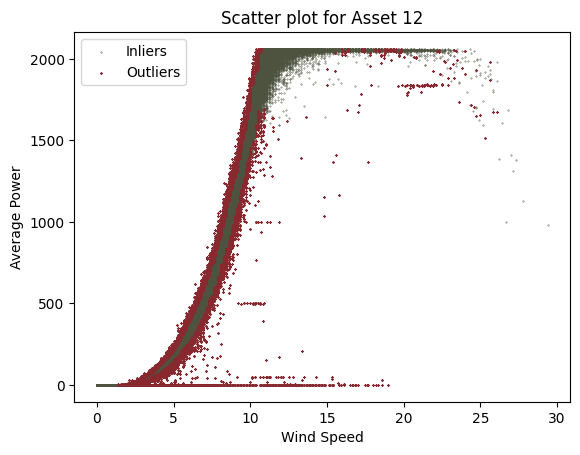

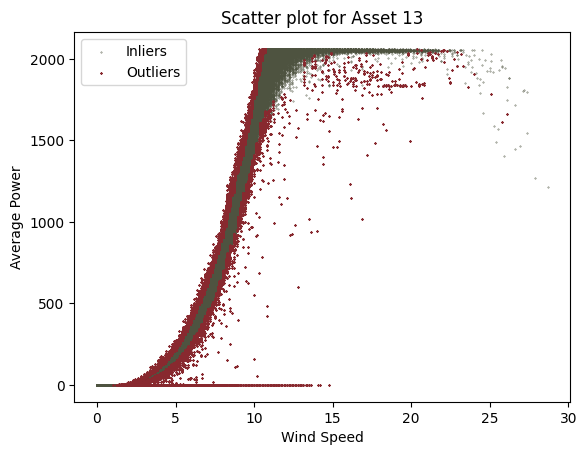

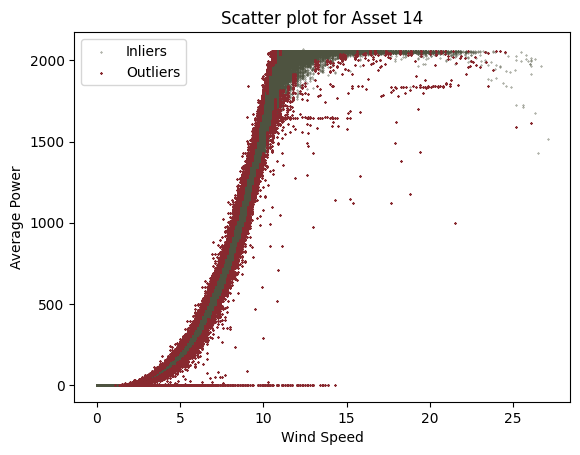

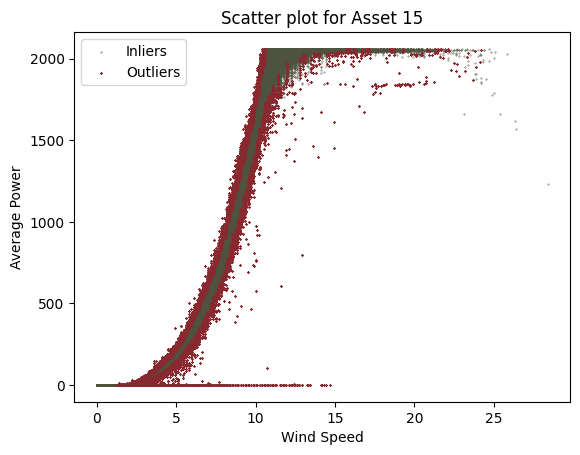

In [ ]:
assets = df_wind["asset_id"].unique()[:5]

# Create an empty list to store outliers for each asset
outliers_list = []

# Group the data by wind speed intervals
wind_speed_intervals = pd.cut(df_wind['wind_speed'], bins=np.arange(0, df_wind['wind_speed'].max() + 0.1, 0.1))
grouped_df = df_wind.groupby([wind_speed_intervals, "asset_id"])

for (wind_speed_interval, asset_id), group_df in grouped_df:
    # Calculate mean power and within-group mean square deviation
    mean_power = group_df['power_average'].mean()
    n = len(group_df)
    mean_square_deviation = np.sqrt(((group_df['power_average'] - mean_power) ** 2).sum() / (n - 1))
    
    # Select the mean square deviation multiplier
    mean_sq_dev_multiplier = 1
    
    # Threshold for identifying outliers
    threshold = mean_sq_dev_multiplier * mean_square_deviation

    # Filter out outliers
    outliers = group_df[(group_df['power_average'] - mean_power).abs() > threshold]

    # Append outliers for each asset to the outliers list
    outliers_list.append(outliers)

# Plot the data points with outliers in a different color
inliers_df = df_wind.drop(pd.concat(outliers_list).index)

for asset_id in assets:
    asset_inliers = inliers_df[inliers_df["asset_id"] == asset_id]
    asset_outliers = pd.concat([outliers[outliers["asset_id"] == asset_id] for outliers in outliers_list])
    
    plt.scatter(asset_inliers["wind_speed"], asset_inliers["power_average"], c="#4E5340", s=0.1)
    plt.scatter(asset_outliers["wind_speed"], asset_outliers["power_average"], c="#88292F", s=1, marker="x")
    
    plt.title(f'Scatter plot for Asset {asset_id}')
    plt.xlabel('Wind Speed')
    plt.ylabel('Average Power')
    plt.legend(['Inliers', 'Outliers'])
    plt.show()
